# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

In [31]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [32]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

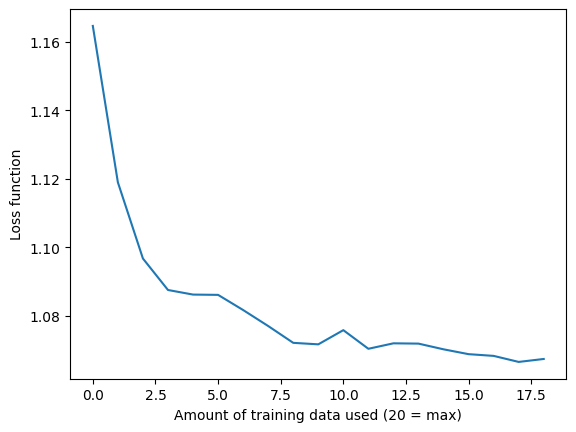

In [33]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [34]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

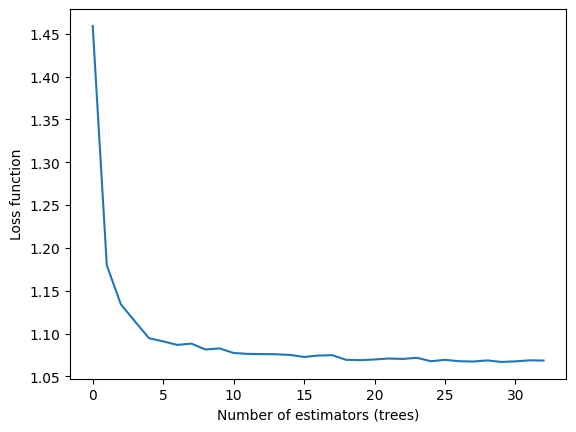

In [35]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

The training size plot tells a better story about a more fundamental phenomenon than the estimators graph. Therefore, I would keep the training size plot.

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

In [99]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "austinHousingData.csv"


df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ericpierce/austinhousingprices",
  file_path,
  # Provide any additional arguments like 
    pandas_kwargs={"sep": ","}
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipykernel_6379/4082401683.py:7: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:          zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  ...  numOfMiddleSchools  \
0             1.98             2            True  ...     

In [100]:
usable_columns = df.select_dtypes(include=['int64', 'float64'])
usable_columns = usable_columns.drop(columns=['zpid'])

In [101]:
usable_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     15171 non-null  int64  
 1   latitude                    15171 non-null  float64
 2   longitude                   15171 non-null  float64
 3   propertyTaxRate             15171 non-null  float64
 4   garageSpaces                15171 non-null  int64  
 5   parkingSpaces               15171 non-null  int64  
 6   yearBuilt                   15171 non-null  int64  
 7   latestPrice                 15171 non-null  float64
 8   numPriceChanges             15171 non-null  int64  
 9   latest_salemonth            15171 non-null  int64  
 10  latest_saleyear             15171 non-null  int64  
 11  numOfPhotos                 15171 non-null  int64  
 12  numOfAccessibilityFeatures  15171 non-null  int64  
 13  numOfAppliances             151

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

X = usable_columns.drop("latestPrice", axis=1)
y = usable_columns["latestPrice"]

iso = IsolationForest(contamination=.01, random_state=42)
outliers = iso.fit_predict(X) == 1
X, y = X[outliers], y[outliers]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred =model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")


RMSE: 164655.7586


In [103]:

importances = model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

print(feat_importance_df)

                       Feature  Importance
20              livingAreaSqFt    0.385975
29              numOfBathrooms    0.135617
0                      zipcode    0.092337
19                 lotSizeSqFt    0.061827
1                     latitude    0.050303
2                    longitude    0.044561
27               avgSchoolSize    0.035737
6                    yearBuilt    0.035082
26             avgSchoolRating    0.023260
10                 numOfPhotos    0.019881
7              numPriceChanges    0.019444
25           avgSchoolDistance    0.018782
8             latest_salemonth    0.012190
12             numOfAppliances    0.010747
15       numOfSecurityFeatures    0.008068
30               numOfBedrooms    0.006571
14  numOfPatioAndPorchFeatures    0.005286
9              latest_saleyear    0.005018
31                numOfStories    0.004435
13        numOfParkingFeatures    0.004334
16     numOfWaterfrontFeatures    0.003954
5                parkingSpaces    0.003902
4          

In [104]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error'
)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)


Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [105]:
best_model = RandomForestRegressor(**grid.best_params_, n_jobs=-1, random_state=42)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [106]:
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {rmse:.2f}")

Final RMSE: 156658.07


So, it appears selecting many features and adding engineered features helped my model immensely. Although the grid searcch actually decreased the RMSE score. I will play around with more models in the future but this was really interesting!

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

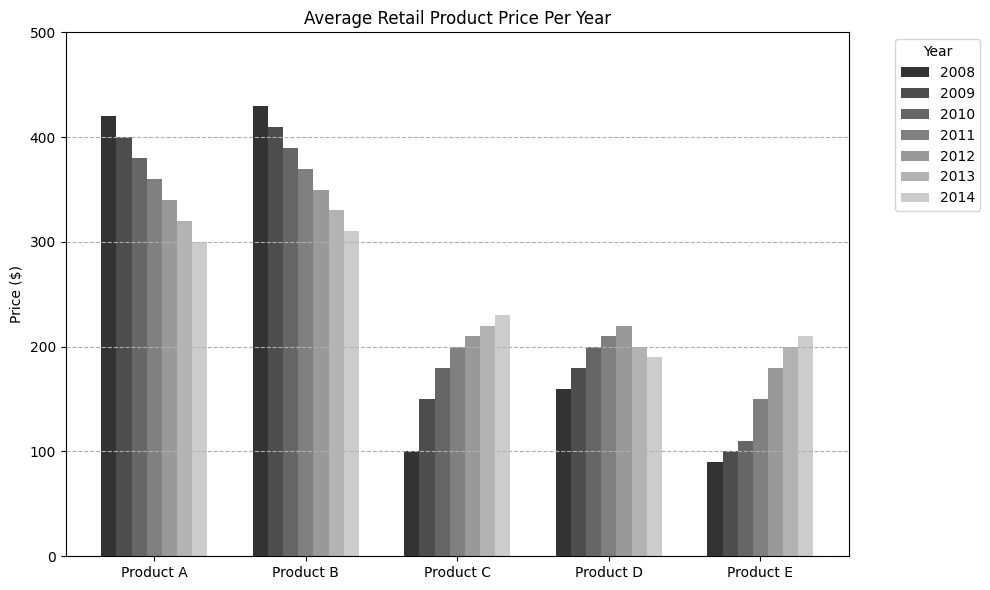

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Product A': [420, 400, 380, 360, 340, 320, 300],
    'Product B': [430, 410, 390, 370, 350, 330, 310],
    'Product C': [100, 150, 180, 200, 210, 220, 230],
    'Product D': [160, 180, 200, 210, 220, 200, 190],
    'Product E': [90, 100, 110, 150, 180, 200, 210],
}
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014]

df = pd.DataFrame(data, index=years)

bar_width = 0.1
x = np.arange(len(df.columns))

fig, ax = plt.subplots(figsize=(10, 6))


for i, year in enumerate(df.index):
    ax.bar(x + i * bar_width, df.loc[year], color=str(0.2 + i * 0.1), width=bar_width, label=year)

ax.set_title("Average Retail Product Price Per Year")
ax.set_xticks(x + bar_width * (len(df.index) - 1) / 2)
ax.set_xticklabels(df.columns)
ax.set_ylabel("Price ($)")
ax.set_ylim(0, 500)
ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

#there were none on those pages but here's one from 190